Clean Text and Categorical Columns

## Data Cleaning: Handle Missing Values, Remove Duplicates, Address Outliers

The data cleaning has been part of our data loading. Here are the steps we did:
1. While the project originated from the amazon.csv dataset, the production environment utilizes MongoDB to serve as the primary data store. This transition was a strategic decision to evolve the project from a local script into a full-fledged eCommerce platform.
2. We wrote a script in /python-services build_artifacts.py, it is written in our readme file.
This is how we initialize project.
   build_artifacts.py - acts as the Automated Pipeline Engine for our recommendation system.
    - Data Extraction & Sanitization -
    
    MongoDB Integration: It connects to our MongoDB instance to pull the live product catalog.

    Deduplication: It automatically removes duplicate product_id entries to ensure the recommendation logic doesn't get "confused" by repeating items.

    Currency Cleaning: It strips symbols like ₹ and commas from price strings, converting them into pure numbers that the mathematical models can process

    Artifact Generation
        The script triggers the creation of the mathematical files (Similarity Matrices)
            cosine_sim_content_pca.npy: The engine for your most accurate content model.
            cosine_sim_reviews.npy: The semantic map for your Review Text expert.
            product_features.parquet: A highly compressed version of your our for near-instant loading, and this will be the basis or start of our modelling process.




In [4]:
import sys
sys.path.append('../src')
import importlib
import data_preprocessing
import pandas as pd
df = pd.read_parquet('../app/dataset/product_features.parquet')

Address outliers

We opted not to perform outlier removal because the Cosine Similarity metric (which we will use in our product recommendation model) is scale-invariant, and our use of PCA effectively mitigated feature noise. Retaining high-variance data points was critical for maintaining the latent factor density required for the SVD collaborative expert

Morever, if we are going to look into our numerical features:
    discounted_price: The price of the product after any applicable discount.
    actual_price: The original, non-discounted price of the product.
    discount_percentage: The percentage reduction from the actual price.
    rating: The user rating given to the product.
    rating_count: The total number of users who have rated the product.
While a comprehensive outlier check could be performed on all five of these features, a strategic decision is made here to focus the resources and analysis effort. In the context of building a product recommendation system, one factor we are checking is the perception of a product's quality and appeal, thus, the most relevant numerical feature for this primary objective is the rating and rating_count.

However, since rating values are typically restricted to a fixed scale (e.g., 1-5), we will not treat outliers as a concern for this particular feature.

The feature rating_count should also not be treated as anomalies that need to be removed ir altered because, a high_rating count usually indicates a popular product that has been purchased and rated by many users, these are not errors but it represents real-world product-success and high engagement

Outliers in discounted_price, actual_price, discount_percentage are secondary concerns that are not central to the current modeling task, if there is a skewed value for price or discount, but for the sake of checking let’s check if there are outliers in these features.

But if we still insist, Checking outliers for discounted_price - we will also apply z-score for this feature.


In [6]:
from scipy.stats import zscore
import numpy as np

# Ensure 'discount_percentage' is numeric before calculating Z-scores
df['discount_percentage'] = df['discount_percentage'].astype(str).str.replace('%', '', regex=False).astype(float)

# Calculate Z-scores for 'discount_percentage'
df['discount_percentage_zscore'] = np.abs(zscore(df['discount_percentage']))

# Define a Z-score threshold (e.g., 3 standard deviations)
z_score_threshold = 3

# Identify outliers
outliers_discount_percentage = df[df['discount_percentage_zscore'] > z_score_threshold]

print(f"Number of outliers in 'discount_percentage' (Z-score > {z_score_threshold}): {len(outliers_discount_percentage)}")
print("\nFirst 5 outliers in 'discount_percentage' (if any):")
display(outliers_discount_percentage.head())


Number of outliers in 'discount_percentage' (Z-score > 3): 0

First 5 outliers in 'discount_percentage' (if any):


,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link,discount_percentage_zscore


The result shows that no outliers in the numeric features of our dataset; consequently, we did not modify any of their values.


# Exploratory Data Analysis (EDA)
This section covers:
- Univariate analysis (distributions)
- Bivariate analysis (relationships)
- Correlation analysis


Descriptive Statistics for 'discounted_price':
count     1351.000000
mean      3304.661858
std       7174.010792
min         39.000000
25%        349.000000
50%        899.000000
75%       2174.000000
max      77990.000000


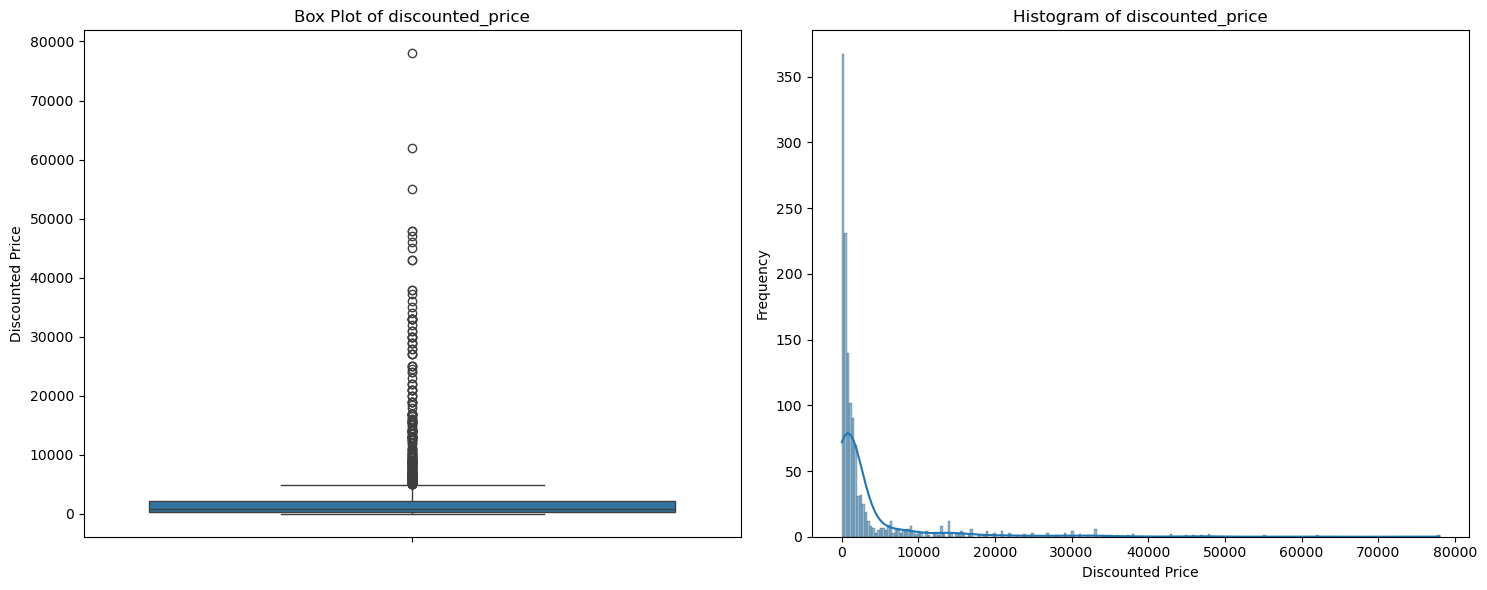


Descriptive Statistics for 'actual_price':
count      1351.000000
mean       5690.510452
std       11218.918302
min          39.000000
25%         899.000000
50%        1790.000000
75%        4575.000000
max      139900.000000


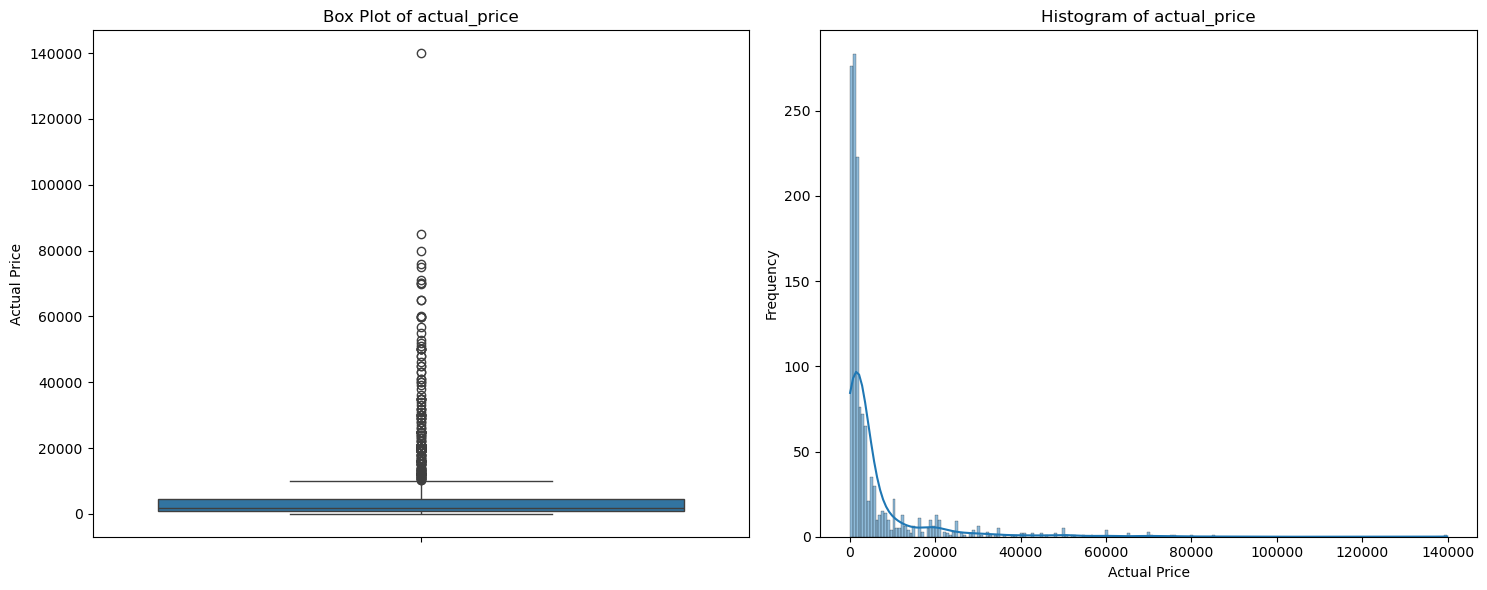


Descriptive Statistics for 'discount_percentage':
count    1351.000000
mean       46.680237
std        21.623168
min         0.000000
25%        31.000000
50%        49.000000
75%        62.000000
max        94.000000


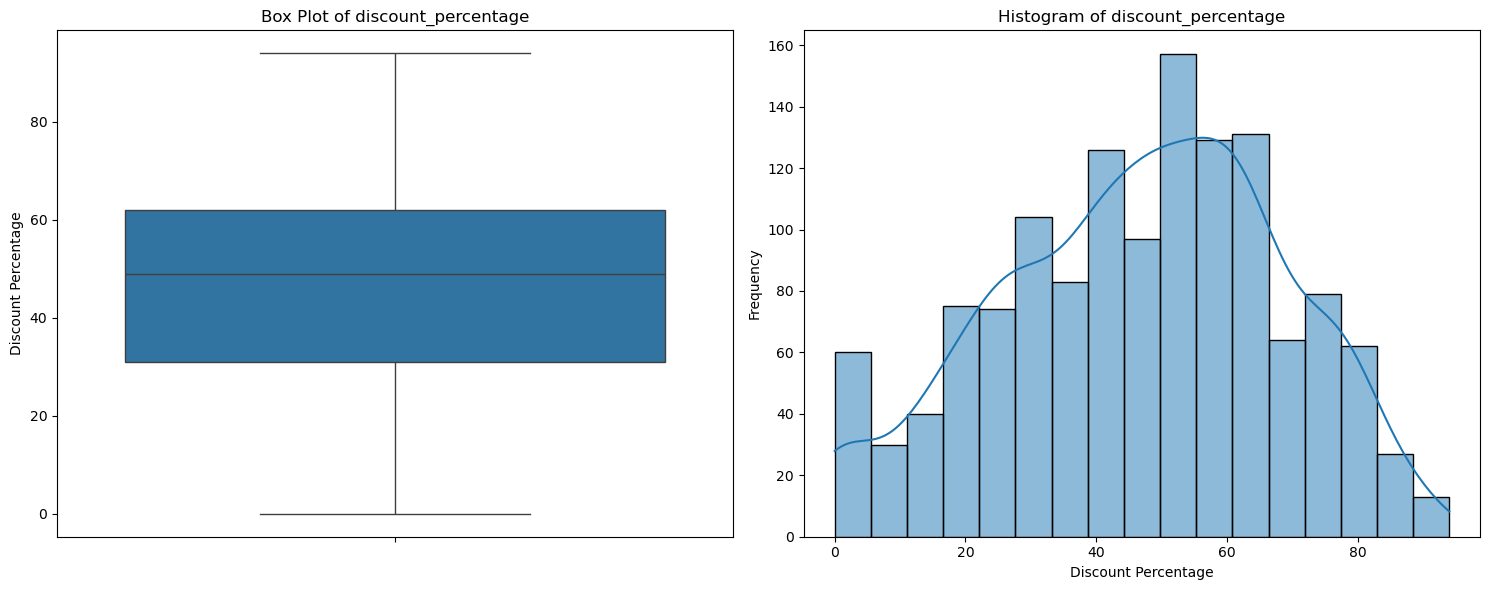


Descriptive Statistics for 'rating':
count    1351.000000
mean        4.088823
std         0.317492
min         0.000000
25%         3.900000
50%         4.100000
75%         4.300000
max         5.000000


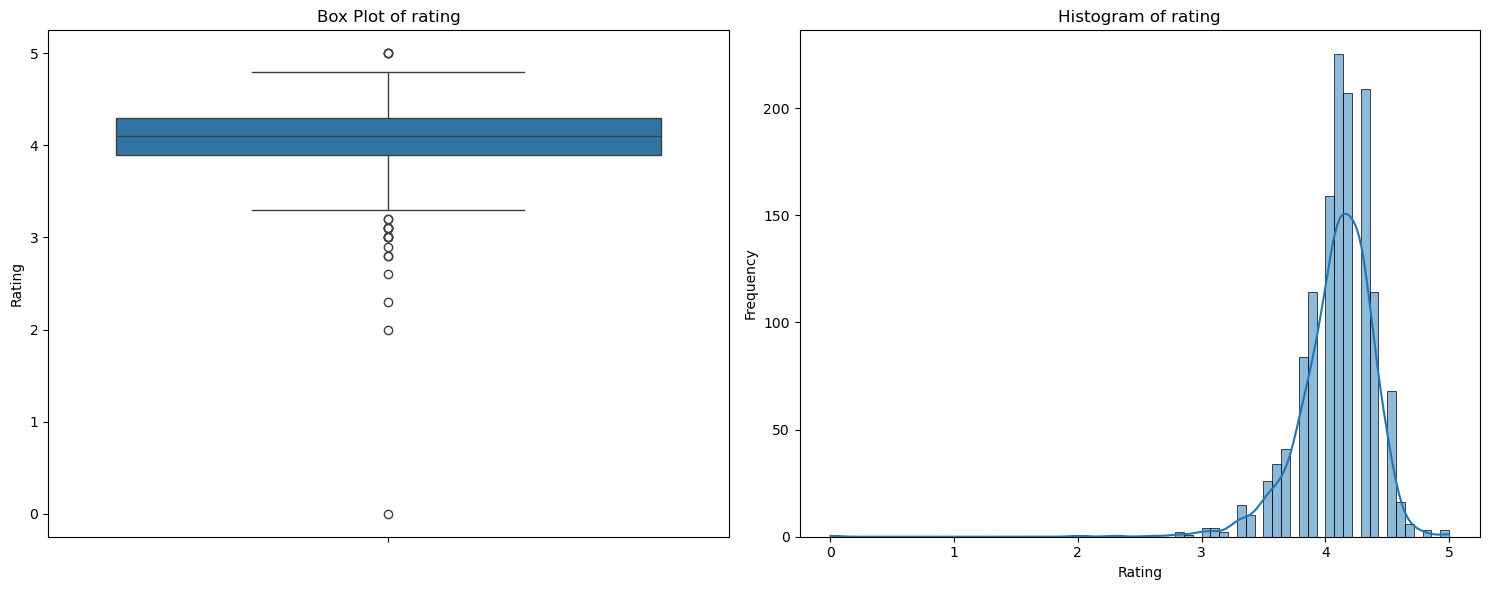


Descriptive Statistics for 'rating_count':
count       1349
unique      1126
top       18,998
freq           8


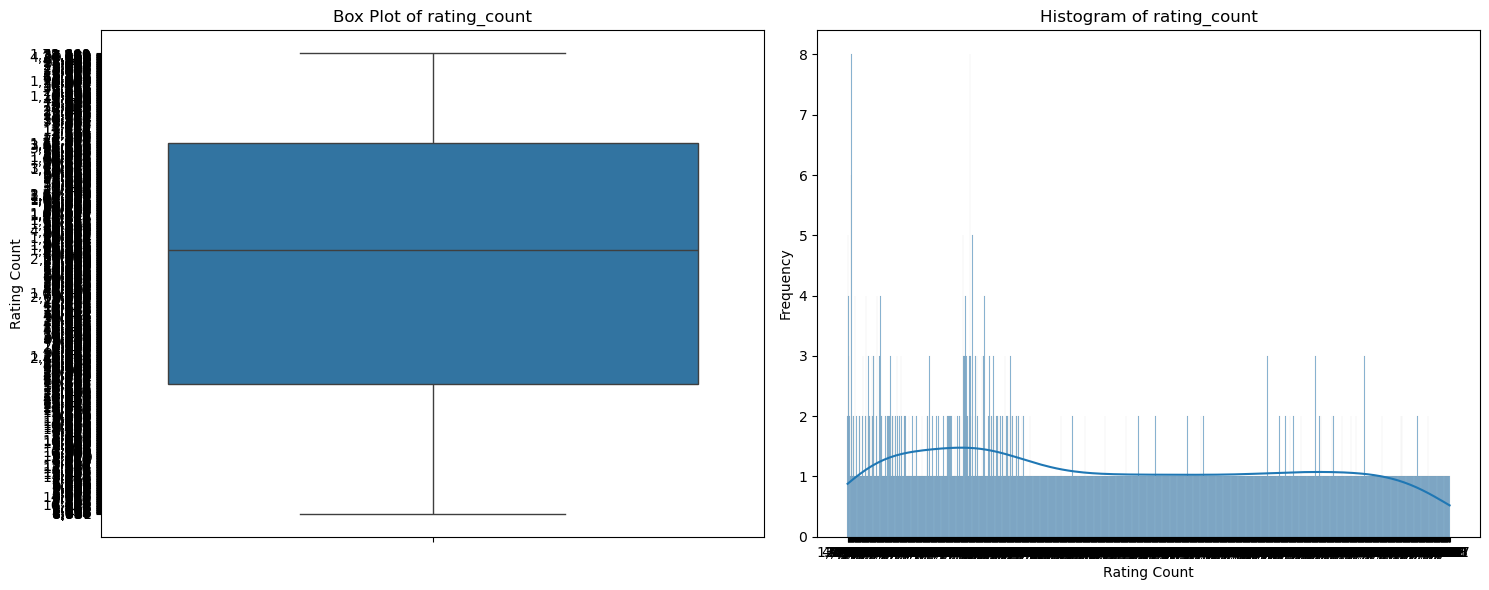

In [5]:
#Univariate Analysis of Numerical Columns
import matplotlib.pyplot as plt
import seaborn as sns

numerical_cols = ['discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count']

for col in numerical_cols:
    print(f"\nDescriptive Statistics for '{col}':")
    print(df[col].describe().to_string())

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Box Plot
    sns.boxplot(y=df[col], ax=axes[0])
    axes[0].set_title(f'Box Plot of {col}')
    axes[0].set_ylabel(col.replace('_', ' ').title())

    # Histogram with KDE
    sns.histplot(df[col], kde=True, ax=axes[1])
    axes[1].set_title(f'Histogram of {col}')
    axes[1].set_xlabel(col.replace('_', ' ').title())
    axes[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()


Interpretation: These box plots are used to identify outliers and understand the interquartile range (IQR). For prices and rating counts, these plots likely show a "heavy-tail" with many extreme values (outliers) on the higher end.
These show the shape of the data distribution. The rating_count and price features show a strong right-skew (the "Long-Tail"), meaning most products are affordable and have few reviews, while a small "head" of products are expensive or viral. The rating histogram typically shows a concentration around the 4.0–4.5 range.

Top 20 Product Categories and their Frequencies:
category
Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|USBCables                        233
Electronics|WearableTechnology|SmartWatches                                                               76
Electronics|Mobiles&Accessories|Smartphones&BasicMobiles|Smartphones                                      68
Electronics|HomeTheater,TV&Video|Televisions|SmartTelevisions                                             63
Electronics|Headphones,Earbuds&Accessories|Headphones|In-Ear                                              52
Electronics|HomeTheater,TV&Video|Accessories|RemoteControls                                               49
Home&Kitchen|Kitchen&HomeAppliances|SmallKitchenAppliances|MixerGrinders                                  27
Electronics|HomeTheater,TV&Video|Accessories|Cables|HDMICables                                            24
Home&Kitchen|Kitchen&HomeAppliances|Vacuum,Cleaning&Ironing|Irons,Stea

/var/folders/60/ksk2php90gg8y49d13k6swkh0000gn/T/ipykernel_24518/990773400.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.index, y=top_categories.values, palette='viridis')
/var/folders/60/ksk2php90gg8y49d13k6swkh0000gn/T/ipykernel_24518/990773400.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout() # Adjust layout to prevent labels from overlapping


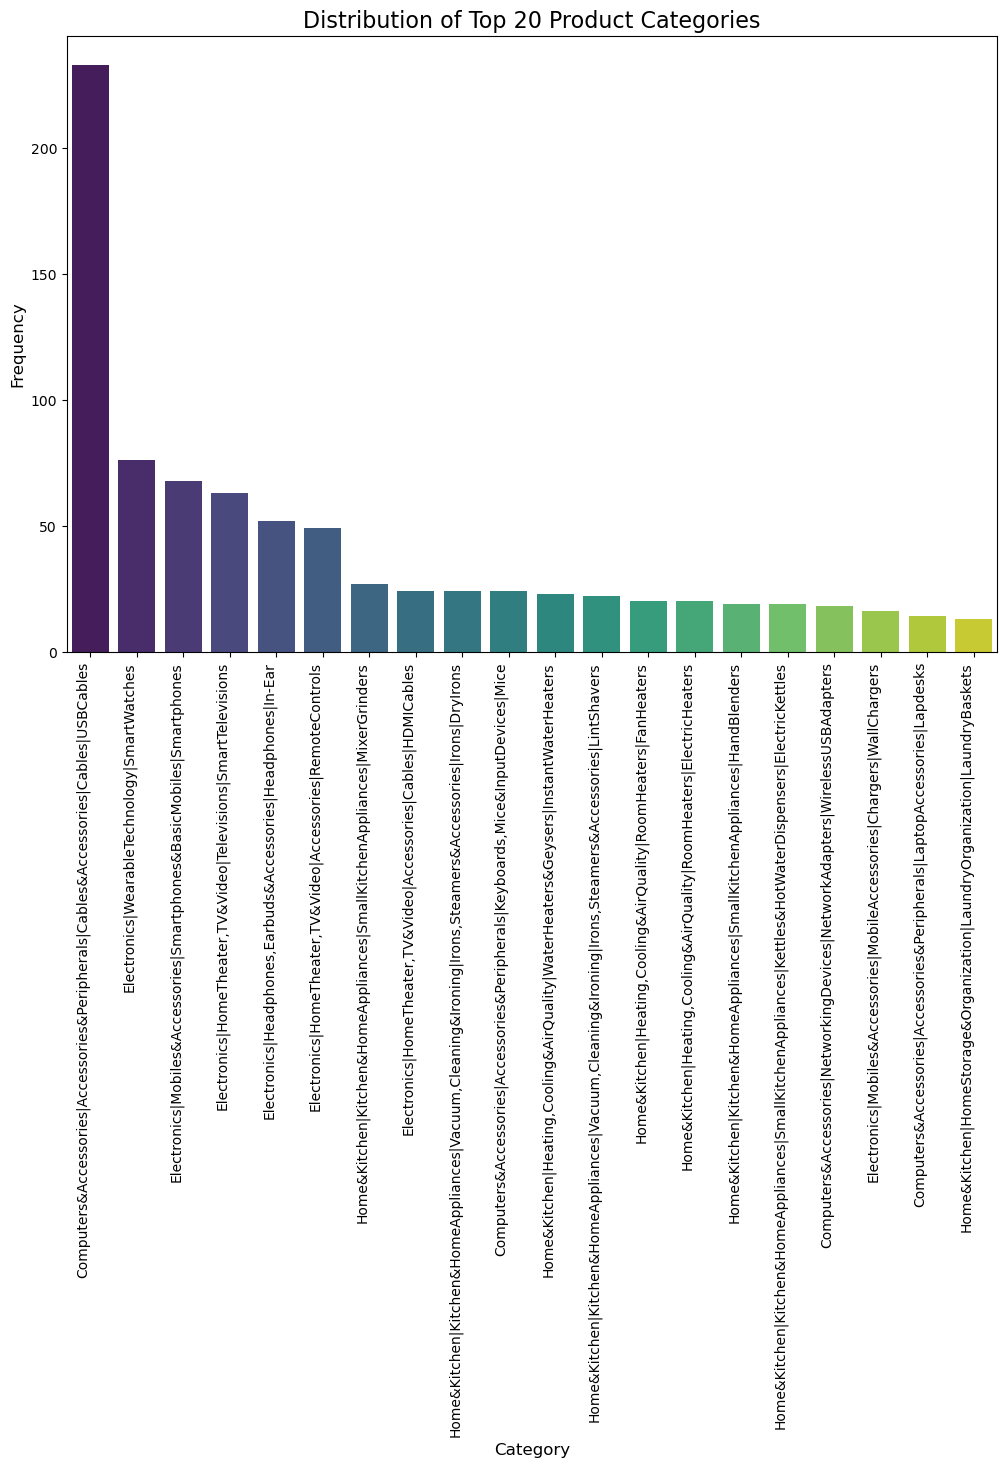

In [51]:
#Univariate Analysis of Categorical Columns
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate and print value counts for the 'category' column (top 20)
top_categories = df['category'].value_counts().head(20)
print("Top 20 Product Categories and their Frequencies:")
print(top_categories.to_string())

# 2. Create a bar plot to visualize the distribution of the top 20 product categories
plt.figure(figsize=(12, 8))
sns.barplot(x=top_categories.index, y=top_categories.values, palette='viridis')

# 3. Ensure the plot has a title, appropriate x and y labels, and rotate x-axis labels
plt.title('Distribution of Top 20 Product Categories', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=90, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping

# 4. Display the plot
plt.show()

Interpretation, this chart visualizes the frequency of the top 20 product categories in the Amazon dataset. It highlights Categorical Dominance. By identifying that certain categories (like "USB Cables" or "Electronics") appear more frequently, we need to highlight this finding that we  need in our recommendation engine needs to be "surgical" in those areas to help users distinguish between many similar items, not only in this heavy dominated products in the top category.

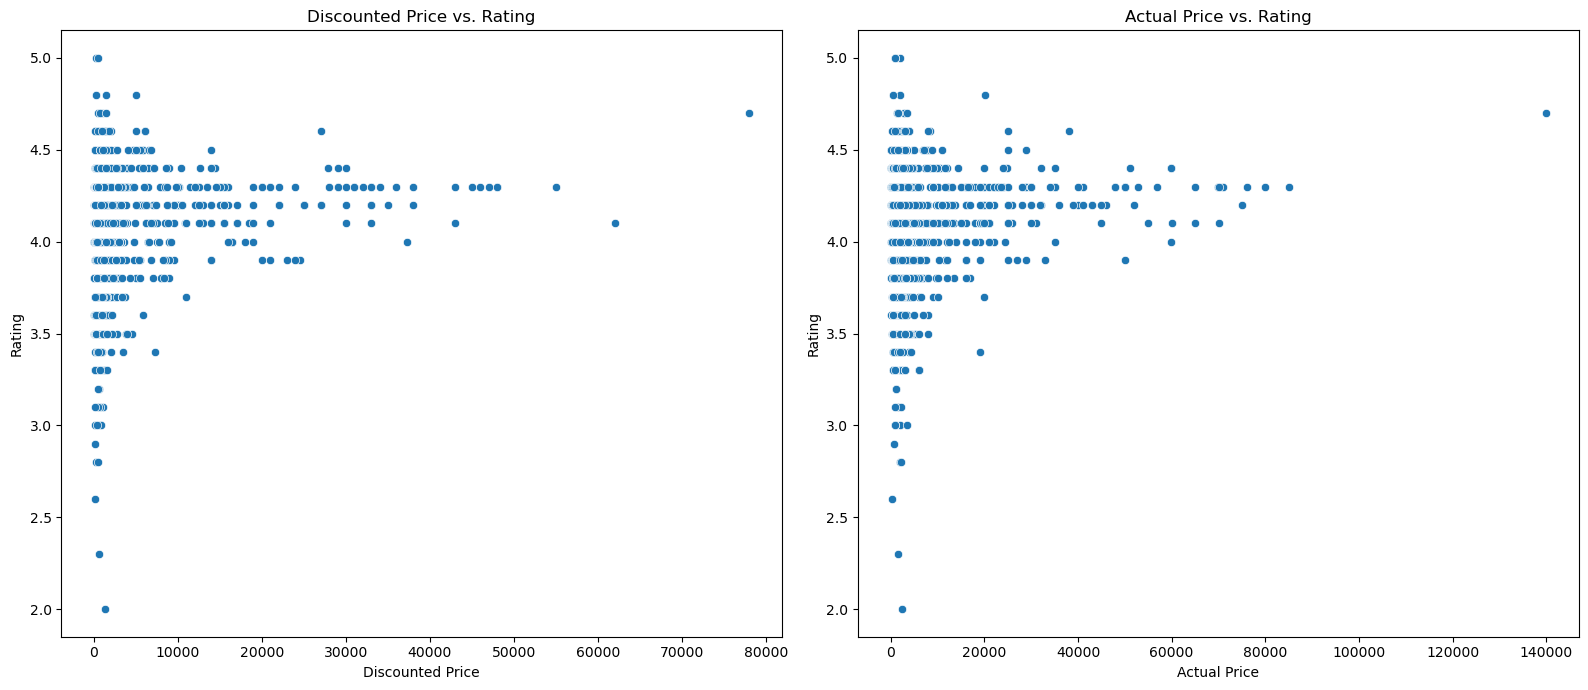

In [52]:
#Bivariate Analysis: Price vs. Rating
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Discounted Price vs. Rating
sns.scatterplot(x=df['discounted_price'], y=df['rating'], ax=axes[0])
axes[0].set_title('Discounted Price vs. Rating')
axes[0].set_xlabel('Discounted Price')
axes[0].set_ylabel('Rating')

# Plot 2: Actual Price vs. Rating
sns.scatterplot(x=df['actual_price'], y=df['rating'], ax=axes[1])
axes[1].set_title('Actual Price vs. Rating')
axes[1].set_xlabel('Actual Price')
axes[1].set_ylabel('Rating')

plt.tight_layout()
plt.show()

These plots explore the relationship between the cost of an item and its customer satisfaction.
This visualization supports our finding of the "Price/Quality Paradox." The scattered nature of the points (with no clear linear trend) proves that a higher price does not necessarily guarantee a higher rating, suggesting that factors other than price (like technical specs or brand trust) drive satisfaction.

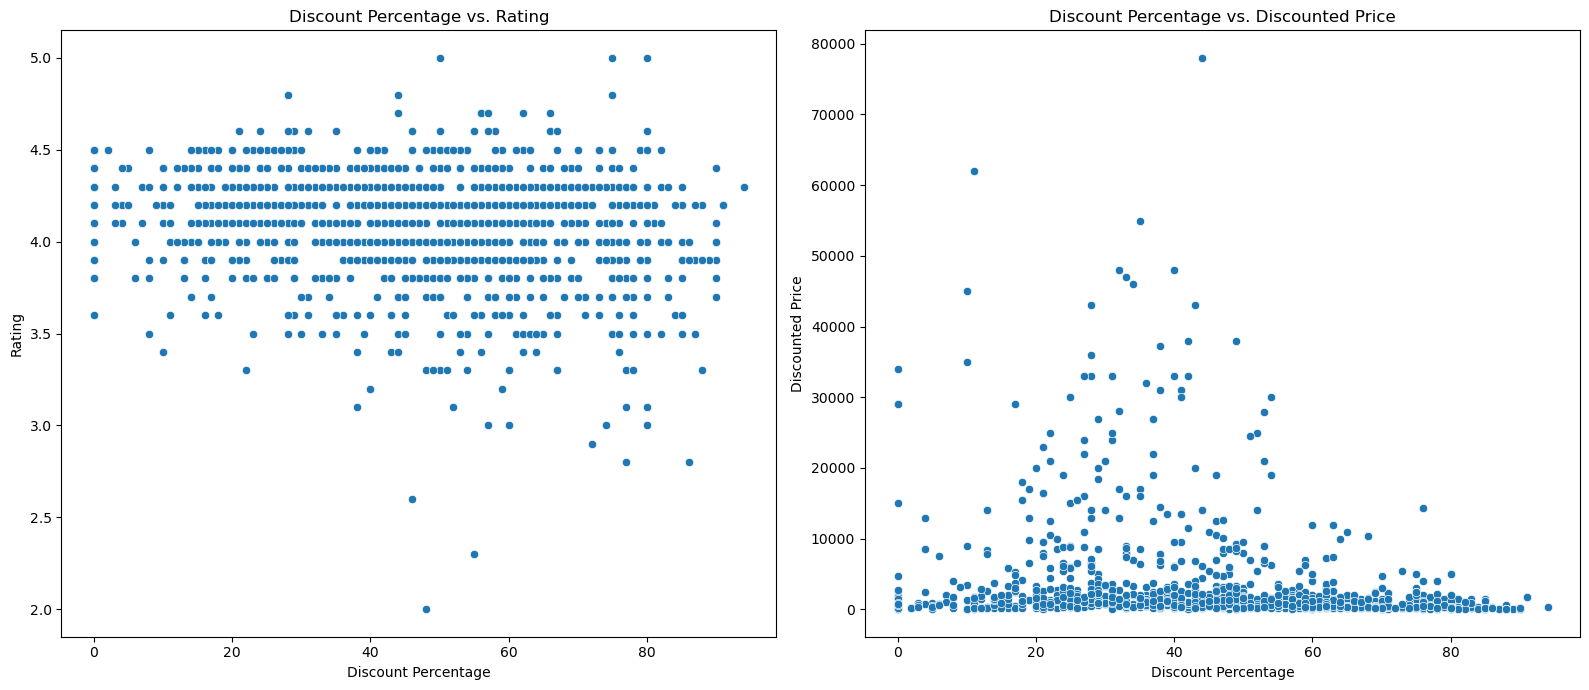

In [53]:
#Bivariate Analysis: Discount vs. Rating/Price
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Discount Percentage vs. Rating
sns.scatterplot(x=df['discount_percentage'], y=df['rating'], ax=axes[0])
axes[0].set_title('Discount Percentage vs. Rating')
axes[0].set_xlabel('Discount Percentage')
axes[0].set_ylabel('Rating')

# Plot 2: Discount Percentage vs. Discounted Price
sns.scatterplot(x=df['discount_percentage'], y=df['discounted_price'], ax=axes[1])
axes[1].set_title('Discount Percentage vs. Discounted Price')
axes[1].set_xlabel('Discount Percentage')
axes[1].set_ylabel('Discounted Price')

plt.tight_layout()
plt.show()

Discount % vs. Rating: Checks if heavily discounted items receive poorer reviews.
Discount % vs. Discounted Price: Visualizes the pricing strategy (e.g., are expensive items the ones getting the 50%+ discounts?).
This helps determine if "bargain hunters" are as satisfied as full-price buyers, this might be critical for the Ethics and Fairness considerations.

Data types of selected columns before correlation:
discounted_price       float64
actual_price           float64
discount_percentage      int64
rating                 float64
rating_count           float64

Correlation Matrix:
                     discounted_price  actual_price  discount_percentage    rating  rating_count
discounted_price             1.000000      0.961915            -0.242412  0.120335     -0.078915
actual_price                 0.961915      1.000000            -0.118098  0.121636     -0.067518
discount_percentage         -0.242412     -0.118098             1.000000 -0.155273      0.093422
rating                       0.120335      0.121636            -0.155273  1.000000     -0.101895
rating_count                -0.078915     -0.067518             0.093422 -0.101895      1.000000


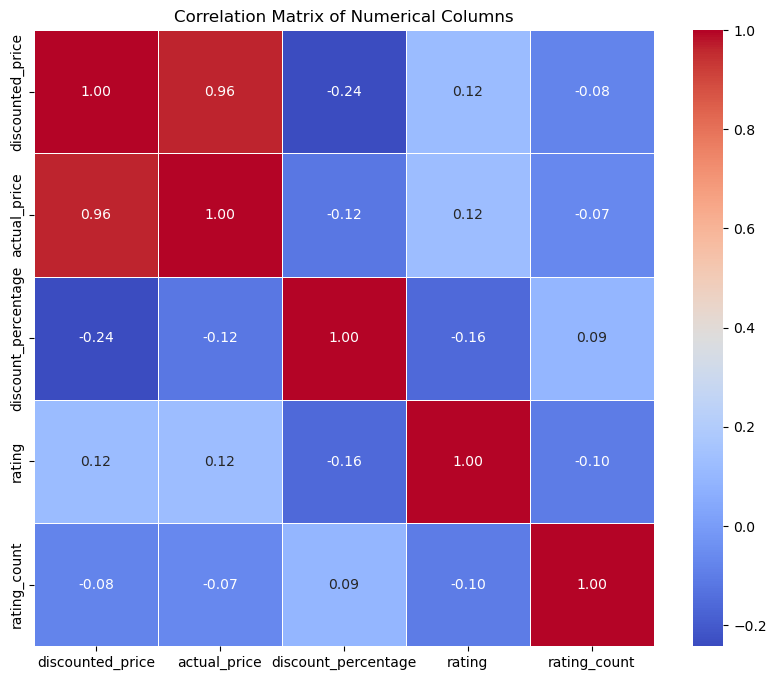

In [54]:
#Correlation Analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Select the relevant numerical columns
correlation_cols = ['discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count']
selected_df = df[correlation_cols].copy() # Use .copy() to ensure we're working on a separate DataFrame

# Ensure all selected columns are numeric and handle any potential remaining non-numeric values
for col in correlation_cols:
    # Convert to numeric, coercing errors will turn non-convertible values into NaN
    selected_df[col] = pd.to_numeric(selected_df[col], errors='coerce')
    
    # Fill any NaNs that might have been introduced by 'coerce' or existed previously
    if col == 'rating_count':
        selected_df[col] = selected_df[col].fillna(0)
    elif col == 'rating':
        selected_df[col] = selected_df[col].fillna(selected_df[col].median())
    else: # For price and percentage columns
        selected_df[col] = selected_df[col].fillna(selected_df[col].mean())

print("Data types of selected columns before correlation:")
print(selected_df.dtypes.to_string())

# Calculate the correlation matrix
correlation_matrix = selected_df.corr()

print("\nCorrelation Matrix:")
print(correlation_matrix.to_string())

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Columns')
plt.show()

This provides a bird's-eye view of the mathematical relationships between all numerical features.
It highlights strong positive correlations (e.g., between actual_price and discounted_price).
It reveals "Near-Zero" correlations (e.g., between discount_percentage and rating),reinforcing the idea that discounts don't negatively impact perceived quality, thus, we can't see relation on "best rated" are the "lowest price".


Final Narrative: From Data Patterns to Product Discovery
This EDA serves as the foundational narrative of our dataset, it allows us to see the underlying patterns that will power our primary objective: the product recommendation engine. By unfolding the story hidden within the raw Amazon metadata, we have moved beyond simple assumptions and decoded the true "statistical DNA" of our catalog.
The Story of Our Features:
The Price/Quality Paradox: Our bivariate and correlation analyses revealed a crucial "plot twist": customer satisfaction is independent of price. High-priced items do not guarantee better ratings, nor do deep discounts automatically drive higher satisfaction.
The Popularity Surge: The heavy right-skew in rating_count identifies our "protagonists"—the viral, high-engagement products that define the market focus of the dataset.
Categorical Dominance: The clear dominance of the USB Cables segment tells us exactly where our engine needs to be the most "surgical," using NLP to differentiate between hundreds of similar items.

	As we have discovered that pricing and ratings are disconnected, our product recommendation engine model cannot rely on a basic sorting logic or category search. Instead, this narrative leads us directly to our Multi-Stage Hybrid Architecture, where Natural Language Processing (NLP) bridges the gap between what a product costs and why a user loves it (reviews).

To further prove our point above we will check Multi-Expert Intent Discovery (The Behavioral vs. Content Gap)

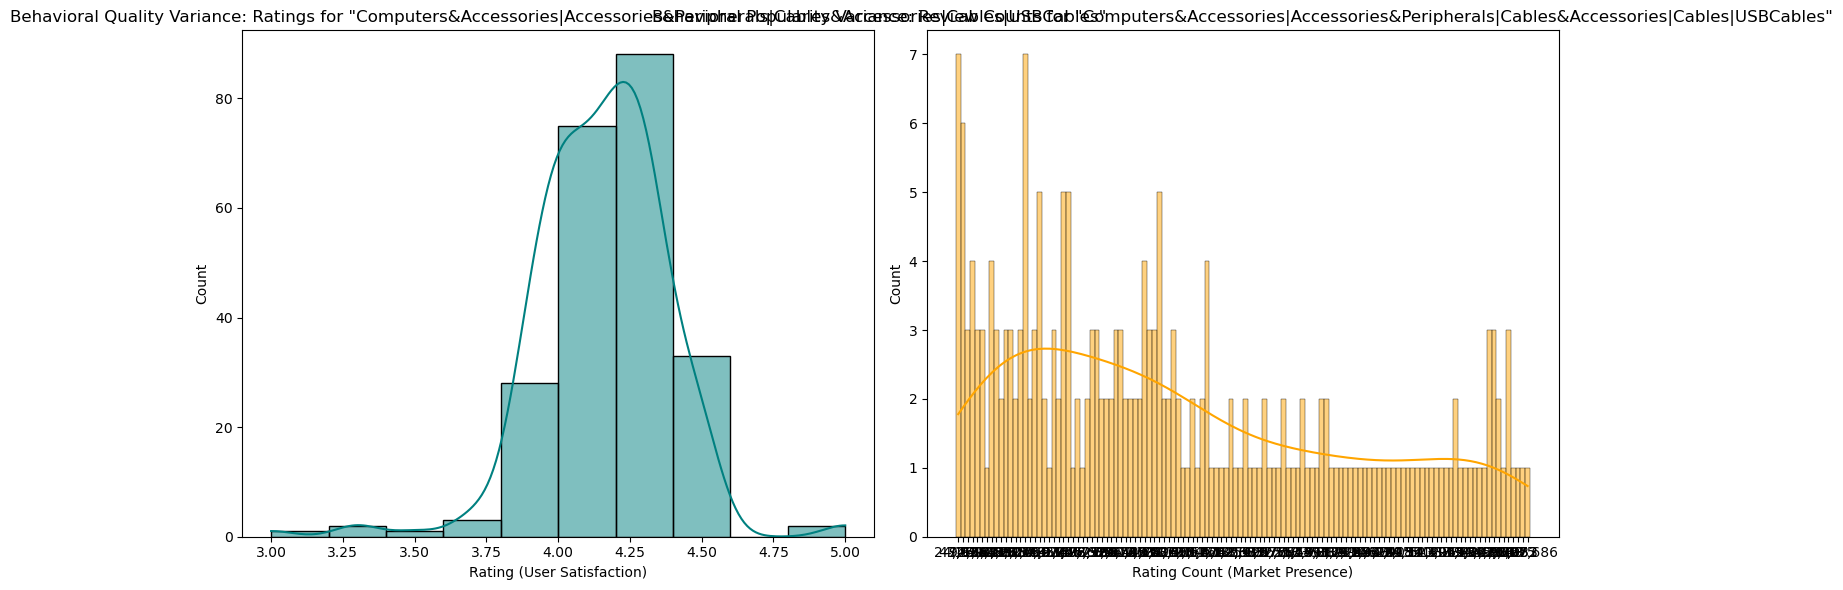

Analysis for Category: Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|USBCables
Mean Rating: 4.15
Standard Deviation of Rating: 0.23


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Select a dominant category to inspect (The "Surgical" Category identified in Cell 11)
target_category = df['category'].value_counts().idxmax()
category_subset = df[df['category'] == target_category]

# 2. Visualize Behavioral Variance within a single Content Group
plt.figure(figsize=(14, 6))

# Subplot 1: Distribution of Ratings within the SAME category
plt.subplot(1, 2, 1)
sns.histplot(category_subset['rating'], bins=10, kde=True, color='teal')
plt.title(f'Behavioral Quality Variance: Ratings for "{target_category}"')
plt.xlabel('Rating (User Satisfaction)')

# Subplot 2: Distribution of Popularity within the SAME category
plt.subplot(1, 2, 2)
sns.histplot(category_subset['rating_count'], bins=20, kde=True, color='orange')
plt.title(f'Behavioral Popularity Variance: Review Counts for "{target_category}"')
plt.xlabel('Rating Count (Market Presence)')

plt.tight_layout()
plt.show()

# 3. Correlation between Category Frequency and Quality
print(f"Analysis for Category: {target_category}")
print(f"Mean Rating: {category_subset['rating'].mean():.2f}")
print(f"Standard Deviation of Rating: {category_subset['rating'].std():.2f}")

The result shows first off the numbers, Standard Deviation of Rating: 0.23 - proves that user satisfaction is not uniform. While the average is 4.15, there is a significant spread. Some cables are likely underperforming near 3.7 while others are elite near 4.6. Every product in this subset belongs to the exact same category:Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|USBCables


 The "Gap" refers to the fact that what a product is (its description, category, and specs) does not always match how people react to it (its ratings, popularity, and reviews).

If we rely on content: If a user searches for "USB Cable," the Content Expert identifies all 1,000 cables in the database, we will miss those scenarios that what if user's only wants the one that won't break in a week, which is behavioral.

What we have proved is that a single-model approach would treat all cables as equal, so we must navigate this 0.23 variance ensuring the user isn't just shown 'a cable,' but 'the best cable' according to the market consensus


